In [1]:
%matplotlib inline
import sys
sys.path.append('../src')
from params import params as P
import numpy as np
import patch_sampling
from parallel import ParallelBatchIterator
np.random.seed(1)
P.DATA_LEVEL=0
import os

Loaded configurations from (in order) ['../src/../config/default.ini', '../src/../config/notebook.ini']
OpenCV 2 NOT AVAILABLE, using skimage/scipy.ndimage instead


In [2]:
P.DATA_FOLDER

'/media/diskB/guido/BreastDataset'

In [3]:
image_path = os.path.join(P.DATA_FOLDER, 'IDC_train/T10-10714-I-5-1_cropped_0.tif')
mask_path = os.path.join(P.DATA_FOLDER, 'AllMasksMerged/T10-10714-I-5-1_cropped_0_Mask.tif')

assert os.path.isfile(image_path)
assert os.path.isfile(mask_path)

In [4]:
sys.path.append('../src/sampler')
import wsi_sampler
import wsi_mask

reload(wsi_sampler); reload(wsi_mask)

m = wsi_mask.WSIMask(mask_path, border_distance=114)

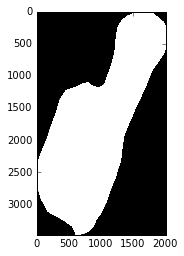

[0 3]


In [5]:
import matplotlib.pyplot as plt
plt.imshow(m.image, cmap='gray')
plt.show()
print np.unique(m.image)

(1074, 3012)


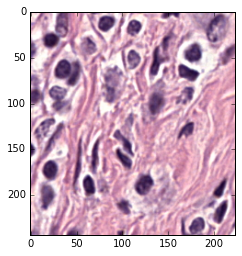

In [6]:
reload(wsi_sampler); reload(wsi_mask)
s = wsi_sampler.WSISampler(image_path, m, 0, (224,244))
image, coord = s.sample(return_position=True)
print coord
plt.imshow(image.transpose(1,2,0))

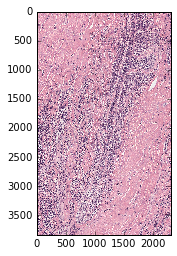

In [7]:
full_image = s.sample_full()
plt.imshow(full_image.transpose(1,2,0))

In [8]:
import multiresolutionimageinterface as mir
import time
from tqdm import tqdm
for x in tqdm(range(5000)):
    mr = mir.MultiResolutionImageReader()
    im = mr.open(image_path)
    im.close()
    
for x in tqdm(range(1000)):
    s.sample()

100%|██████████| 1000/1000 [00:05<00:00, 176.65it/s]


In [9]:
import dataset
files = dataset.train_filenames()
len(files)
len(files[0]), len(files[1]), len(files[2])

files, mask_sources = dataset.per_class_filelist(files[0],files[1],files[2],dataset.mask_folder(),{},(1352,670,832))


In [10]:
print len(files)
print len(mask_sources)

from multiprocessing.pool import ThreadPool as Pool
import util
import joblib

def create_sampler(wsi_filename):
    mask_filename = mask_sources[wsi_filename]
    mask = wsi_mask.WSIMask(mask_path, border_distance=112)
    sampler = wsi_sampler.WSISampler(image_path, mask, 0, (224,244))
    return sampler

pool = Pool(6)
samplers = list(util.pool_progress(pool, create_sampler, files))

    

  0%|          | 0/2854 [00:00<?, ?it/s]

2854
2854


100%|██████████| 2854/2854 [05:08<00:00,  8.92it/s]


In [18]:
import cPickle as pickle

pool.close()
pool.join()

with open('/mnt/diskB/guido/samplers.pkl','wb') as f:
    pickle.dump(samplers,f, protocol=2)


In [22]:
del samplers
del samplers_loaded


In [20]:
import time
s = time.time()
with open('/mnt/diskB/guido/samplers.pkl','rb') as f:
    samplers_loaded = pickle.load(f)
print time.time() - s
# 165.624352932


165.624352932


In [15]:
del samplers_loaded
import gzip
with gzip.open('/mnt/diskB/guido/samplers.pkl.gz','wb') as f:
    pickle.dump(samplers,f, protocol=2)
    


In [23]:
import time
s = time.time()
with gzip.open('/mnt/diskB/guido/samplers.pkl.gz','rb') as f:
    samplers_loaded = pickle.load(f)
print time.time() - s
# 51.4443669319


51.4443669319
